In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings('ignore', category=UserWarning)

In [4]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from dataset import TranslationDataset
from model import Seq2SeqTransformer
from train import train
from tqdm.notebook import tqdm

In [5]:
SRC_LANGUAGE = 'de'
TRG_LANGUAGE = 'en'
BATCH_SIZE = 64

In [6]:
train_dataset = TranslationDataset('data/train.de-en.de', 'data/train.de-en.en', SRC_LANGUAGE, TRG_LANGUAGE)
val_dataset = TranslationDataset('data/val.de-en.de', 'data/val.de-en.en', SRC_LANGUAGE, TRG_LANGUAGE,)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=train_dataset.build_collate_fn())
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=val_dataset.build_collate_fn())

In [7]:
SRC_VOCAB_SIZE, TRG_VOCAB_SIZE = train_dataset.vocab_sizes

print(f"Vocabs are built with lengths:\n"
      f"Train - {SRC_VOCAB_SIZE}\n"
      f"Val - {TRG_VOCAB_SIZE}")

EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
NUM_ENCODER_LAYERS = 6
NUM_DECODER_LAYERS = 6
DROPOUT = 0.1
MAX_LEN = 128

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TRG_VOCAB_SIZE, FFN_HID_DIM, DROPOUT, MAX_LEN).to(device)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

Vocabs are built with lengths:
Train - 272269
Val - 111592


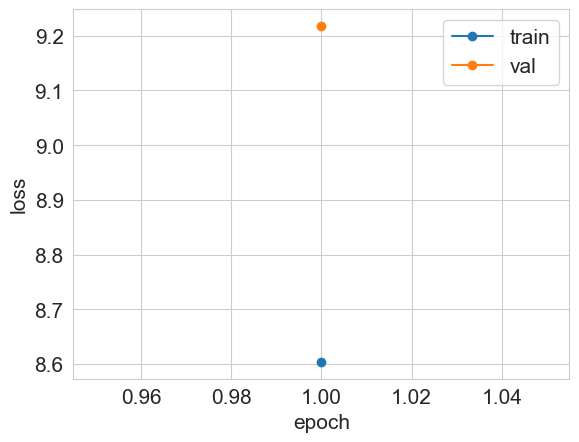

In [8]:
NUM_EPOCHS = 1

train(model, train_loader, val_loader, optimizer, NUM_EPOCHS, device, True)

In [14]:
test_dataset = TranslationDataset('data/test1.de-en.de', src_language=SRC_LANGUAGE, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=test_dataset.build_collate_fn())
trg_vocab = train_dataset.vocabs[TRG_LANGUAGE]

cnt = 0
with open('predictions.txt', 'w') as pred:
    for src, trg in tqdm(test_loader, desc='Predicting'):
        translation = model.translate(src, trg_vocab, device)
        pred.write(translation + '\n')
        if cnt < 7:
            print(translation)
        cnt += 1

# translate(model, src_test_file, tgt_test_file, sp_model_path, device, 128)

Predicting:   0%|          | 0/7 [00:00<?, ?it/s]

tensor([ 2, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17])
the the the the the the the the the the the the the the 
tensor([ 2, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 17, 17, 17, 17, 17])
the the the the the the the the the the the the the the the the the the the the the the the 
tensor([ 2, 17, 17, 17, 17, 17, 17, 17, 17, 17])
the the the the the the the the the 
tensor([ 2, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17])
the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 
tensor([ 2, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 17, 17, 17, 17, 17, 17, 17, 17, 17])
the the the the the the

In [30]:
# class CustomTransformerModel(nn.Module):
#     def __init__(self, src_vocab_size, tgt_vocab_size, emb_size=512, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048, dropout=0.1):
#         super(CustomTransformerModel, self).__init__()
#         self.src_tok_emb = nn.Embedding(src_vocab_size, emb_size)
#         self.tgt_tok_emb = nn.Embedding(tgt_vocab_size, emb_size)
#         self.positional_encoding = PositionalEncoding(emb_size, dropout)

#         self.encoder_layer = nn.TransformerEncoderLayer(d_model=emb_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
#         self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)

#         self.decoder_layer = nn.TransformerDecoderLayer(d_model=emb_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
#         self.transformer_decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_decoder_layers)

#         self.generator = nn.Linear(emb_size, tgt_vocab_size)

#     def forward(self, src, tgt, src_mask=None, tgt_mask=None, src_padding_mask=None, tgt_padding_mask=None):
#         src_emb = self.positional_encoding(self.src_tok_emb(src))
#         tgt_emb = self.positional_encoding(self.tgt_tok_emb(tgt))

#         memory = self.transformer_encoder(src_emb, mask=src_mask, src_key_padding_mask=src_padding_mask)
#         outs = self.transformer_decoder(tgt_emb, memory, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_padding_mask)
        
#         return self.generator(outs)

# class PositionalEncoding(nn.Module):
#     def __init__(self, embedding_dim, dropout=0.1, max_len=5000):
#         super(PositionalEncoding, self).__init__()
#         self.dropout = nn.Dropout(p=dropout)

#         position = torch.arange(max_len).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, embedding_dim, 2) * -(math.log(10000.0) / embedding_dim))
#         pe = torch.zeros(max_len, embedding_dim)
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe = pe.unsqueeze(0)
#         self.register_buffer('pe', pe)

#     def forward(self, x):
#         res_pe = self.pe[:, :x.size(1)]
#         x = x + res_pe
#         return self.dropout(x)

In [92]:
# class SimpleSeq2Seq(nn.Module):
#     def __init__(self, input_dim, output_dim, emb_dim, hid_dim, n_layers, dropout, device):
#         super().__init__()
#         self.encoder_embedding = nn.Embedding(input_dim, emb_dim)
#         self.decoder_embedding = nn.Embedding(output_dim, emb_dim)
#         self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout, bidirectional=True)
#         self.fc = nn.Linear(hid_dim * 2, output_dim)
#         self.dropout = nn.Dropout(dropout)
#         self.device = device

#     def forward(self, src, trg, teacher_forcing_ratio=0.5):
#         embedded = self.dropout(self.encoder_embedding(src))
#         encoder_outputs, (hidden, cell) = self.rnn(embedded)

#         trg_len = trg.shape[0]
#         batch_size = trg.shape[1]
#         outputs = torch.zeros(trg_len, batch_size, self.fc.out_features).to(self.device)

#         input = trg[0,:]
#         for t in range(1, trg_len):
#             embedded = self.dropout(self.decoder_embedding(input)).unsqueeze(0)
#             output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
#             output = self.fc(output.squeeze(0))
#             outputs[t] = output
#             top1 = output.argmax(1) 
#             input = trg[t] if random.random() < teacher_forcing_ratio else top1

#         return outputs

In [94]:
# def translate(model, src_sequence, sp_model, device, max_length=50):
#     model.eval()
#     with torch.no_grad():
#         src_tensor = torch.tensor([src_sequence], dtype=torch.long).to(device)
#         src_tensor = src_tensor.transpose(0, 1)
#         outputs = [sp_model.bos_id()]
        
#         for i in range(max_length):
#             trg_tensor = torch.LongTensor(outputs).unsqueeze(1).to(device)
            
#             with torch.no_grad():
#                 output = model(src_tensor, trg_tensor)
            
#             best_guess = output.argmax(2)[-1, :].item()
#             outputs.append(best_guess)

#             if best_guess == sp_model.eos_id():
#                 break
        
#         translated_sentence = sp_model.decode(outputs)
#         return translated_sentence

# def evaluate_bleu(model, val_loader, sp_model, device):
#     model.eval()
#     refs = []
#     hyps = []
#     for src, trg in val_loader:
#         src, trg = src.to(device), trg.to(device)
        
#         for i in range(src.shape[1]):
#             src_sequence = src[:, i].tolist()
#             translated_sentence = translate(model, src_sequence, sp_model)
#             hyps.append(translated_sentence)
            
#             trg_sequence = trg[:, i].tolist()
#             true_sentence = sp_model.decode(trg_sequence)
#             refs.append([true_sentence])
    
#     bleu_score = sacrebleu.corpus_bleu(hyps, refs)
#     return bleu_score.score

# def training_epoch(model, train_loader, optimizer, criterion, tqdm_desc, device):
#     model.train()
#     train_loss = 0
#     for src, trg in tqdm(train_loader, desc=tqdm_desc):
#         src, trg = src.to(device), trg.to(device)
#         optimizer.zero_grad()
#         output = model(src, trg)
#         output_dim = output.shape[-1]
#         output = output[:, :-1].contiguous().view(-1, output_dim)
#         trg = trg[:, 1:].contiguous().view(-1)
#         loss = criterion(output, trg)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()
#     return train_loss / len(train_loader)


# def evaluate(model, val_loader, criterion, tqdm_desc, device):
#     model.eval()
#     total_loss = 0
#     with torch.no_grad():
#         for src, trg in tqdm(val_loader, desc=tqdm_desc):
#             src, trg = src.to(device), trg.to(device)
#             output = model(src, trg[:, :-1])
#             output_dim = output.shape[-1]
#             output = output.contiguous().view(-1, output_dim)
#             trg = trg[:, 1:].contiguous().view(-1)
#             loss = criterion(output, trg)
#             total_loss += loss.item()
#     return total_loss / len(val_loader)



# def train(model, train_loader, val_loader, optimizer, criterion, device, epochs=10):
#     train_losses, val_losses, val_bleus = [], [], []
#     for epoch in range(1, epochs + 1):
#         train_loss = training_epoch(model, train_loader, optimizer, criterion, f"Trainig {epoch}/{epochs}", device)
#         val_loss = evaluate(model, val_loader, criterion, f"Validating {epoch}/{epochs}", device)
#         val_bleu = evaluate_bleu(model, val_loader, val_loader.dataset.sp_model, device)

#         train_losses.append(train_loss)
#         val_losses.append(val_loss)
#         val_bleus.append(val_bleu)
#         plot_losses(train_losses, val_losses, val_bleus)